# DATA2001 Group Assignment: Quantifying Resource Availability in Greater Sydney SA2 Regions
**Authors:**  
- 530377104  
- 530675262  
- 530762481

## 1. Setup & Dependencies

### 1.1 Imports

In [123]:
# Standard library
import json
import requests

# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd

# Database connectivity
from sqlalchemy import create_engine, text
from geoalchemy2 import Geometry, WKTElement

# Spatial geometry
from shapely.geometry import MultiPolygon, Point, Polygon

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import folium
from folium.plugins import FeatureGroupSubGroup, MarkerCluster

# Statistical analysis
from scipy.stats import pearsonr, spearmanr

### 1.2 PostgreSQL Connector Setup
To streamline database interactions, we define a pgconnect() function that reads connection details from Credentials.json and creates a SQLAlchemy engine pointing to our Postgres instance. This centralizes all authentication and configuration in one place. We then use a query() helper that takes an open connection and a SQL string, executes the statement, and returns the results directly as a pandas DataFrame—making it trivial to pull data from the database into our analysis pipeline.

In [125]:
credentials = "Credentials.json"
def pgconnect(credential_filepath, db_schema="public"):
    """
    Reads credentials.json, prefers the 'database' key, then 'dbname',
    then falls back to the user. Returns (engine, connection).
    """
    with open(credential_filepath, "r") as f:
        creds = json.load(f)

    host   = creds["host"]
    port   = creds["port"]
    user   = creds["user"]
    pw     = creds["password"]
    dbname = creds.get("database") or creds.get("dbname") or user

    url = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{dbname}"

    try:
        engine = create_engine(url, echo=False)
        conn   = engine.connect()
        print(f"Connected successfully to '{dbname}'.")
    except Exception as e:
        print("Unable to connect to the database:")
        print(e)
        engine, conn = None, None

    return engine, conn

def query(engine, sqlcmd, args=None, df=True):
    """
    Convenience wrapper around pandas.read_sql_query or raw execute.
    - If df=True: returns a DataFrame via pandas.read_sql_query()
    - Else: runs a raw execute() on engine and returns fetched results.
    """
    try:
        if df:
            return pd.read_sql_query(sqlcmd, engine, params=args)
        else:
            result = engine.execute(text(sqlcmd), args).fetchall()
            return result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered:", e)
        return None


### 1.3 Establish Database Connection
This line invokes our connector and prepares the session for all subsequent database work:

In [127]:
db, conn = pgconnect(credentials)

Connected successfully to 'postgres'.


### 1.4 Verify PostGIS Installation
Before running any spatial operations, we perform a quick sanity check by calling the PostGIS_Version() function through our query() helper. A returned version string confirms that the PostGIS extension is installed and that spatial SQL functions are available in the database.

In [129]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.5 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


## 2. Data Ingestion 

### 2.1 Create Core Spatial Tables
Establishes the initial PostGIS schema for SA2 boundaries and transport stops by creating (or recreating) the public.sa2_regions and public.stops tables. These tables are defined with appropriate geometry columns (MULTIPOLYGON for regions, POINT for stops) and GIST indexes to ensure efficient spatial querying. The sa2_regions table created here serves as a preliminary structure that will be further refined.

In [132]:
create_sa2_sql = """
DROP TABLE IF EXISTS public.sa2_regions;
CREATE TABLE public.sa2_regions (
    sa2_code_2021 TEXT PRIMARY KEY,
    sa2_name_2021 TEXT,
    geometry      GEOMETRY(MULTIPOLYGON,4326)
);
CREATE INDEX IF NOT EXISTS sa2_regions_geom_idx
    ON public.sa2_regions USING GIST (geometry);

DROP TABLE IF EXISTS public.stops;
CREATE TABLE public.stops (
    stop_id   TEXT PRIMARY KEY,
    stop_name TEXT,
    geometry  GEOMETRY(POINT,4326)
);
CREATE INDEX IF NOT EXISTS stops_geom_idx
    ON public.stops USING GIST (geometry);
"""

conn.execute(text(create_sa2_sql))
print("\nCore spatial tables (sa2_regions, stops) structure created/recreated.")


Core spatial tables (sa2_regions, stops) structure created/recreated.


### 2.2 Import Core CSV Tables
Loads business, income, and population data from their respective CSV files. The raw data is initially previewed for structural verification, then deduplicated, and finally loaded into the public.businesses, public.population, and public.income tables in PostgreSQL. This step prepares these foundational datasets for analytical use and linkage with other data.

In [134]:
import pandas as pd
from sqlalchemy import text

# Load CSVs
business = pd.read_csv("data/Businesses.csv")
print("Businesses.csv head:")
print(business.head())

income = pd.read_csv("data/income.csv")
print("\nincome.csv head:")
print(income.head())

population = pd.read_csv("data/Population.csv")
print("\nPopulation.csv head:")
print(population.head())

# Clean 'income' data: Convert 'np' and other invalid values to NULL (NaN)
income.replace("np", pd.NA, inplace=True)
for col in ["earners", "median_age", "median_income", "mean_income"]:
    income[col] = pd.to_numeric(income[col], errors="coerce")

# Define SQL schema creation
create_sa2_sql_query = """
DROP TABLE IF EXISTS public.businesses;
CREATE TABLE public.businesses (
    industry_code TEXT,
    industry_name TEXT,
    sa2_code TEXT,
    sa2_name TEXT,
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code)
);

DROP TABLE IF EXISTS public.income;
CREATE TABLE public.income (
    sa2_code21 TEXT PRIMARY KEY,
    sa2_name TEXT,
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);

DROP TABLE IF EXISTS public.population;
CREATE TABLE public.population (
    sa2_code TEXT PRIMARY KEY,
    sa2_name TEXT,
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    total_people INTEGER
);
"""

# Execute schema creation
conn.execute(text(create_sa2_sql_query))
print("\nCreated business, income and population tables.")

# Insert data
business.to_sql("businesses", conn, schema="public", if_exists="append", index=False, method="multi")
income.to_sql("income", conn, schema="public", if_exists="append", index=False, method="multi")
population.to_sql("population", conn, schema="public", if_exists="append", index=False, method="multi")

print("Data inserted successfully.")


Businesses.csv head:
  industry_code                      industry_name   sa2_code  \
0             A  Agriculture, Forestry and Fishing  101021007   
1             A  Agriculture, Forestry and Fishing  101021008   
2             A  Agriculture, Forestry and Fishing  101021009   
3             A  Agriculture, Forestry and Fishing  101021010   
4             A  Agriculture, Forestry and Fishing  101021012   

                          sa2_name  0_to_50k_businesses  \
0                        Braidwood                  136   
1                          Karabar                    6   
2                       Queanbeyan                    6   
3                Queanbeyan - East                    0   
4  Queanbeyan West - Jerrabomberra                    7   

   50k_to_200k_businesses  200k_to_2m_businesses  2m_to_5m_businesses  \
0                      92                     63                    4   
1                       3                      0                    0   
2             

In [135]:
for table in ["businesses", "income", "population"]:
    result = conn.execute(text(f"SELECT COUNT(*) FROM public.{table}"))
    count = result.scalar()
    print(f"{table}: {count} rows")

businesses: 12217 rows
income: 642 rows
population: 373 rows


### 2.3 Load SA2 Boundary Shapefile into PostGIS
Loads SA2 geographic boundaries into the public.sa2_regions PostGIS table. Data is read from an SA2 shapefile, processed to standardize column names (including sa2_code, sa2_name, sa4_name_2021, gcc_name_2021), ensure the CRS is EPSG:4326, and remove duplicates. This processed data then replaces any prior version of the public.sa2_regions table. Finally, a primary key on sa2_code and a GIST spatial index on the geometry are conditionally created to ensure data integrity and optimize spatial analysis.

In [ ]:
sa2 = (
    gpd.read_file("data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")[
        ["SA2_CODE21", "SA2_NAME21", "SA4_NAME21", "GCC_NAME21", "geometry"]
    ]
    .rename(
        columns={
            "SA2_CODE21": "sa2_code",
            "SA2_NAME21": "sa2_name",
            "SA4_NAME21": "sa4_name_2021",
            "GCC_NAME21": "gcc_name_2021",
        }
    )
    .to_crs(4326)
    .drop_duplicates()
)

sa2.to_postgis(
    "sa2_regions", conn,
    schema="public",
    if_exists="replace",
    index=False,
    dtype={"geometry": Geometry("MULTIPOLYGON", 4326)}
)
print(f"\nInserted {len(sa2):,} SA2 rows, replacing sa2_regions table.")

conn.execute(text("""
DO $$
BEGIN
  IF NOT EXISTS (
      SELECT 1 FROM pg_constraint
      WHERE conrelid = 'public.sa2_regions'::regclass
        AND conname = 'sa2_regions_pkey'
  ) THEN
      ALTER TABLE public.sa2_regions
        ADD CONSTRAINT sa2_regions_pkey PRIMARY KEY (sa2_code);
  END IF;

  IF NOT EXISTS (
      SELECT 1 FROM pg_indexes
      WHERE schemaname = 'public'
        AND tablename  = 'sa2_regions'
        AND indexname  = 'sa2_regions_geom_idx'
  ) THEN
      CREATE INDEX sa2_regions_geom_idx
        ON public.sa2_regions USING GIST (geometry);
  END IF;
END $$;
"""))
print("Primary key and GIST index on sa2_regions verified/created.")

### 2.4 Insert Transport Stops from GTFS
Populates the public.stops table with public transport stop locations. Data sourced from Stops.txt (typically part of a GTFS feed) is deduplicated and transformed into a spatial format by creating POINT geometries from latitude/longitude coordinates (CRS EPSG:4326). These stop locations are then appended to the public.stops table, leveraging the schema and GIST index established earlier, to provide a spatial layer for transit infrastructure analysis.

In [139]:
stops = pd.read_csv("data/Stops.txt")
stops.drop_duplicates(inplace=True)

stops_gdf = gpd.GeoDataFrame(
    stops[["stop_id","stop_name"]],
    geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
    crs=4326
)

stops_gdf.to_postgis("stops", conn,
                     schema="public",
                     if_exists="append",
                     index=False,
                     dtype={"geometry": Geometry("POINT",4326)})

print(f"\nInserted {len(stops_gdf):,} stops into public.stops table.")


Inserted 114,718 stops into public.stops table.


### 2.5 Load School Catchment Polygons
Integrates school catchment boundaries into the public.schools PostGIS table. Data from separate shapefiles for primary, secondary, and future catchments is read, standardized (CRS to EPSG:4326, columns renamed, 'sector' attribute added), consolidated, and deduplicated. This comprehensive catchment data is then loaded into a newly created public.schools table, structured with a surrogate primary key (gid), MULTIPOLYGON geometry, and a GIST spatial index to facilitate analysis of educational access areas.

In [141]:
def read_catch(path):
    gdf = gpd.read_file(path).to_crs(4326)
    gdf = gdf.rename(columns={
        "USE_ID": "school_id",
        "CATCH_TYPE": "stage"
    })
    gdf["sector"] = "Government"
    return gdf[["school_id", "sector", "stage", "geometry"]]

gdf_primary   = read_catch("data/catchments/catchments_primary.shp")
gdf_secondary = read_catch("data/catchments/catchments_secondary.shp")
gdf_future    = read_catch("data/catchments/catchments_future.shp")

schools = pd.concat([gdf_primary, gdf_secondary, gdf_future], ignore_index=True)
schools.drop_duplicates(inplace=True)
print(f"\nTotal unique school polygons prepared: {len(schools):,}")

conn.execute(text("""
DROP TABLE IF EXISTS public.schools;
CREATE TABLE public.schools (
    gid       SERIAL PRIMARY KEY,
    school_id TEXT,
    sector    TEXT,
    stage     TEXT,
    geometry  GEOMETRY(MULTIPOLYGON,4326)
);
CREATE INDEX schools_geom_idx
  ON public.schools USING GIST (geometry);
"""))
print("Recreated public.schools table with GIST index.")

schools.to_postgis("schools", conn, schema="public",
                   if_exists="append", index=False,
                   dtype={"geometry": Geometry("MULTIPOLYGON",4326)})
print("School catchments loaded into public.schools table.")


Total unique school polygons prepared: 2,125
Recreated public.schools table with GIST index.
School catchments loaded into public.schools table.


### 2.6 Build Indexes on SA2 Key Columns
Optimizes data retrieval performance by creating B-tree indexes on the SA2 key columns (e.g., sa2_code or sa2_code21) within the public.businesses, public.population, and public.income tables. These indexes are created if they don't already exist and significantly accelerate join operations between these attribute tables and the public.sa2_regions spatial table, enabling efficient linkage of demographic and economic data to geographic areas.

In [143]:
conn.execute(text("""
    CREATE INDEX IF NOT EXISTS businesses_sa2_idx
      ON public.businesses (sa2_code);
    CREATE INDEX IF NOT EXISTS population_sa2_idx
      ON public.population (sa2_code);
    CREATE INDEX IF NOT EXISTS income_sa2_idx
      ON public.income (sa2_code21);
"""))
print("\nIndexes created on sa2_code columns for businesses, population, and income tables.")


Indexes created on sa2_code columns for businesses, population, and income tables.


### 2.7 Validate Table Loads
Confirms the completeness of the data ingestion process by querying and displaying the row counts for all key tables created or populated in the public schema: sa2_regions, stops, schools, businesses, population, and income. This serves as a fundamental validation step to ensure that each dataset has been loaded as expected.

In [145]:
print("\nRow counts in public tables:")
row_counts_df = pd.read_sql("""
SELECT 'sa2_regions' AS table_name, COUNT(*) AS rows FROM public.sa2_regions
UNION ALL
SELECT 'stops',        COUNT(*) FROM public.stops
UNION ALL
SELECT 'schools',      COUNT(*) FROM public.schools
UNION ALL
SELECT 'businesses',   COUNT(*) FROM public.businesses
UNION ALL
SELECT 'population',   COUNT(*) FROM public.population
UNION ALL
SELECT 'income',       COUNT(*) FROM public.income;
""", conn)
print(row_counts_df)


Row counts in public tables:
    table_name    rows
0   population     373
1       income     642
2   businesses   12217
3  sa2_regions    2473
4      schools    2125
5        stops  114718


### 2.8 Confirm Spatial Metadata
Verifies the consistency of spatial data across the database by querying the geometry_columns system catalog. This lists all tables in the public schema that contain geometry columns, along with their Spatial Reference ID (SRID). This check ensures that all spatial data correctly uses the designated coordinate system (e.g., EPSG:4326), which is crucial for accurate spatial operations and analysis.

In [147]:
print("\nSRID of geometry columns in public schema:")
srid_df = pd.read_sql("""
SELECT f_table_schema AS schema_name, f_table_name AS table_name, f_geometry_column AS geometry_column, srid
FROM   geometry_columns
WHERE  f_table_schema = 'public';
""", conn)
print(srid_df)


SRID of geometry columns in public schema:
  schema_name   table_name geometry_column  srid
0      public        stops        geometry  4326
1      public  sa2_regions        geometry  4326
2      public      schools        geometry  4326


### 2.9 Connection Diagnostics
Provides diagnostic information about the current database connection by displaying the SQLAlchemy engine URL, the DSN (Data Source Name) parameters of the connection, and the name of the currently active database (queried directly). This output helps in verifying that the script is connected to the intended database environment and can aid in troubleshooting any connection-related issues.

In [149]:
if 'engine' in locals() or 'engine' in globals():
    print("\nengine    →", engine.url)
else:
    print("\nEngine object 'engine' not found for diagnostics.")

if 'conn' in locals() and conn and conn.connection:
    try:
        dsn_params = conn.connection.get_dsn_parameters()
        print("conn DSN  →", dsn_params)
        current_db_df = pd.read_sql(text("SELECT current_database()"), conn) # conn instead of db
        print("current_db→", current_db_df.iloc[0,0])
    except AttributeError:
        print("Could not retrieve DSN parameters or current_database using this connection object.")
    except Exception as e:
        print(f"An error occurred during connection diagnostics: {e}")
else:
    print("Connection object 'conn' not available or not active for diagnostics.")


Engine object 'engine' not found for diagnostics.
conn DSN  → {'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'}
current_db→ postgres


### 2.10 WEB API

this code queries the NSW SIX Maps POI API to retrieve POIs within specified bounding box defined by minimum and maximum longitude and latitude coordinates. It sends an HTTP GET request with spatial parameters, parsed the returned JSON response, and then extracts relevant POI attributes and coordinates. The result is returned as a Pandas DataFrame containing POI name, type, group, labels, and geographic location, along with the raw JSON response for optional inspection

In [152]:
def get_pois_from_api(minx, miny, maxx, maxy):
    
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    
    params = {
        "where": "1=1",
        "geometry": f"{minx},{miny},{maxx},{maxy}",
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "returnGeometry": "true",
        "f": "json"
    }
    
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print("Error fetching data:", response.status_code)
        return pd.DataFrame(), {}
    
    result = response.json()

    if "features" not in result:
        return pd.DataFrame(), result
    
    pois = []
    
    for feature in result["features"]:
        attr = feature["attributes"]
        geom = feature.get("geometry", {})
        
        pois.append({
            "POIName": attr.get("poiname", None),
            "POIType": attr.get("poitype", None),
            "POIGroup": attr.get("poigroup", None),
            "POILabel": attr.get("poilabel", None),
            "POIAltLabel": attr.get("poialtlabel", None),
            "POILabelType": attr.get("poilabeltype", None),
            "Longitude": geom.get("x", None),
            "Latitude": geom.get("y", None)
        })
    
    return pd.DataFrame(pois), result


This code retreives POIs for SA2 regions within our selected SA4 areas (Sydney - Blacktown, Parramatta, and Ryde) by querying their bounding boxes from a PostgreSQL. It parses the bounding box coordinates, calls the provided API to fetch POIs for each region, appends SA2 metadata to the results, and pauses between requests for 1s to not hit API limits. The collected POIs are then combined and stored in the nsw_poi table within the database, replacing any existing data

In [154]:
import time
from sqlalchemy import text, String, Integer, Float, DateTime

selected_sa4 = ["Sydney - Blacktown", "Sydney - Parramatta", "Sydney - Ryde"]
selected_sa4_str = ", ".join(f"'{sa4}'" for sa4 in selected_sa4)

sa2_df = pd.read_sql(f"""
SELECT sa2_code, sa2_name, sa4_name_2021, ST_Extent(geometry) AS bbox
FROM public.sa2_regions
WHERE sa4_name_2021 IN ({selected_sa4_str})
GROUP BY sa2_code, sa2_name, sa4_name_2021
""", conn)

def bbox_parse(bbox_str):
    bbox_str = bbox_str.replace("BOX(", "").replace(")", "")
    min_point, max_point = bbox_str.split(",")
    minx, miny = map(float, min_point.strip().split(" "))
    maxx, maxy = map(float, max_point.strip().split(" "))
    return minx, miny, maxx, maxy

sa2_df[["min_lon", "min_lat", "max_lon", "max_lat"]] = sa2_df["bbox"].apply(lambda x: pd.Series(bbox_parse(x)))

results = []

for index, row in sa2_df.iterrows():
    sa2_code = row["sa2_code"]
    sa2_name = row["sa2_name"]
    min_lon = row["min_lon"]
    min_lat = row["min_lat"]
    max_lon = row["max_lon"]
    max_lat = row["max_lat"]

    print(f"Fetching POIs for SA2: {sa2_name}")

    poi_df, result_p = get_pois_from_api(min_lon, min_lat, max_lon, max_lat)
    # print(result_p)

    if poi_df.empty:
        continue

    poi_df["SA2_CODE"] = sa2_code
    poi_df["SA2_NAME"] = sa2_name
    results.append(poi_df)

    time.sleep(1)

print("Finished fetching POIs.")

if results:
    final_poi_df = pd.concat(results, ignore_index=True)
    print(f"Total POIs fetched: {len(final_poi_df)}")
    display(final_poi_df.head())
    

    final_poi_df.to_sql("nsw_poi", db, if_exists="replace", index=False, dtype={
        "POIName": String(),
        "POIType": String(),
        "POIGroup": Integer(),
        "POILabel": String(),
        "POIAltLabel": String(),
        "POILabelType": String(),
        "Longitude": Float(),
        "Latitude": Float(),
        "SA2_CODE": String(),
        "SA2_NAME": String(),
        "timestamp": String()   
    })

    print("POIs successfully inserted into table 'nsw_poi'.")
else:
    print("No POIs found.")

Fetching POIs for SA2: Blacktown (East) - Kings Park
Fetching POIs for SA2: Blacktown (North) - Marayong
Fetching POIs for SA2: Doonside - Woodcroft
Fetching POIs for SA2: Lalor Park - Kings Langley
Fetching POIs for SA2: Blacktown - South
Fetching POIs for SA2: Blacktown - West
Fetching POIs for SA2: Seven Hills - Prospect
Fetching POIs for SA2: Toongabbie - West
Fetching POIs for SA2: Glenwood
Fetching POIs for SA2: Acacia Gardens
Fetching POIs for SA2: Quakers Hill
Fetching POIs for SA2: Kellyville Ridge - The Ponds
Fetching POIs for SA2: Marsden Park - Shanes Park
Fetching POIs for SA2: Riverstone
Fetching POIs for SA2: Schofields (West) - Colebee
Fetching POIs for SA2: Schofields - East
Fetching POIs for SA2: Stanhope Gardens - Parklea
Fetching POIs for SA2: Bidwill - Hebersham - Emerton
Fetching POIs for SA2: Glendenning - Dean Park
Fetching POIs for SA2: Hassall Grove - Plumpton
Fetching POIs for SA2: Lethbridge Park - Tregear
Fetching POIs for SA2: Mount Druitt - Whalan
Fetchin

,POIName,POIType,POIGroup,POILabel,POIAltLabel,POILabelType,Longitude,Latitude,SA2_CODE,SA2_NAME
0,BREWONGLE WALKWAY,Park,3,BREWONGLE WALKWAY,None,NAMED,150.898434,-33.777748,116011303,Blacktown (East) - Kings Park
1,None,Park,3,Park,None,GENERIC,150.902324,-33.781609,116011303,Blacktown (East) - Kings Park
2,None,Park,3,Park,None,GENERIC,150.899557,-33.781500,116011303,Blacktown (East) - Kings Park
3,None,Park,3,Park,None,GENERIC,150.899392,-33.779309,116011303,Blacktown (East) - Kings Park
4,None,Park,3,Park,None,GENERIC,150.905749,-33.781910,116011303,Blacktown (East) - Kings Park


POIs successfully inserted into table 'nsw_poi'.


## 3. Score Calculation

### 3.1 Business z-Score 

We focus on industries that directly provide everyday goods, services, and amenities to local residents. To that end, we exclude:

- **Heavy-industry & utilities**  
  _(Mining, Manufacturing, Agriculture, Electricity/Gas/Water/Waste, Construction)_  
  These sectors typically locate outside dense population centers and don’t reflect the local availability of shops, clinics, or leisure services.

- **Public Administration & Safety**  
  Although essential, these are government-run functions rather than private-sector businesses, and so are better handled by dedicated public-sector layers.

- **Administrative & Support Services**  
  Roles like cleaning, security, or back-office operations don’t signal consumer-facing amenities; they rarely indicate local resource richness from a resident’s perspective.

In [158]:
sql = text("""
DROP TABLE IF EXISTS public.sa2_summary;

CREATE TABLE public.sa2_summary AS
SELECT
  sr.sa2_code,
  sr.sa2_name,
  SUM(b.total_businesses)
    / (pop.total_people   / 1000.0) AS business_count
FROM businesses b
  JOIN sa2_regions    sr  USING (sa2_name)
  JOIN population pop USING (sa2_name)
WHERE sr.sa4_name_2021 IN (
    'Sydney - Blacktown',
    'Sydney - Parramatta',
    'Sydney - Ryde'
  )
  AND b.industry_name IN (
    'Health Care and Social Assistance',
    'Education and Training',
    'Retail Trade',
    'Accommodation and Food Services',
    'Transport, Postal and Warehousing',
    'Financial and Insurance Services',
    'Professional, Scientific and Technical Services',
    'Arts and Recreation Services',
    'Rental, Hiring and Real Estate Services'
  )
  AND total_people >= 100
GROUP BY
  sr.sa2_code,
  sr.sa2_name,
  pop.total_people
""")

conn.execute(sql)


summary_df = query(conn, "SELECT * FROM public.sa2_summary;")
print(summary_df.head())

    sa2_code                       sa2_name  business_count
0  116011303  Blacktown (East) - Kings Park       98.009545
1  116011304   Blacktown (North) - Marayong       42.186973
2  116011306           Doonside - Woodcroft       38.427319
3  116011307     Lalor Park - Kings Langley       51.711324
4  116011560              Blacktown - South       41.788220


### 3.2 Transport Stops z-Score  

We quantify local transit access by counting every bus, train and tram stop located within each SA2 boundary. A higher `stops_count` not only signals more frequent service options, but also reflects greater ease of movement—letting residents run errands, commute or access leisure activities without relying on a car. By mapping stop density in this way, we capture how well-connected each neighbourhood is to the wider city network.

In [161]:
sql = text("""
-- 1) Add the new column if it doesn't already exist
ALTER TABLE public.sa2_summary
ADD COLUMN IF NOT EXISTS stops_count INTEGER;

-- 2) Update that column by counting stops per SA2
UPDATE public.sa2_summary AS summ
SET stops_count = sub.stops_count
FROM (
  SELECT
    sr.sa2_name,
    COUNT(*) AS stops_count
  FROM sa2_regions AS sr
  JOIN stops AS s
    ON ST_Contains(sr.geometry, s.geometry)
  WHERE
    sr.sa4_name_2021 IN (
      'Sydney - Blacktown',
      'Sydney - Parramatta',
      'Sydney - Ryde'
    )
  GROUP BY
    sr.sa2_name
) AS sub
WHERE summ.sa2_name = sub.sa2_name;
""")

conn.execute(sql)

summary_df = query(
    conn,
    "SELECT * FROM public.sa2_summary;"
)
print(summary_df.head())

    sa2_code                       sa2_name  business_count  stops_count
0  116011303  Blacktown (East) - Kings Park       98.009545          228
1  116011304   Blacktown (North) - Marayong       42.186973          234
2  116011306           Doonside - Woodcroft       38.427319          221
3  116011307     Lalor Park - Kings Langley       51.711324          345
4  116011560              Blacktown - South       41.788220           82


### 3.3 Schools z-Score

We gauge local education availability by counting the number of unique school-catchment polygons that overlap each SA2, then normalizing this as **catchments per 1 000 young residents**. Higher values indicate more schooling options relative to the size of the youth population.

- We derive **young_pop** by summing age bands 0–4, 5–9, 10–14 and 15–19 for each SA2.  
- We exclude any SA2 with **young_pop < 100** to avoid unstable per-capita rates in areas with very few children.  
- The raw catchment count is divided by **(young_pop / 1 000)**, ensuring that areas with smaller youth populations don’t produce disproportionately large metrics.  

In [164]:
sql = text("""
-- 1) Add the new column if it doesn't already exist
ALTER TABLE public.sa2_summary
ADD COLUMN IF NOT EXISTS catchments_count DOUBLE PRECISION;

-- 2) Update that column by computing catchments per 1 000 young people
WITH pop_young AS (
  SELECT
    sa2_name,
    (
      "0-4_people"
    + "5-9_people"
    + "10-14_people"
    + "15-19_people"
    ) AS young_pop
  FROM population
)
UPDATE public.sa2_summary AS summ
SET catchments_count = sub.catchments_count
FROM (
  SELECT
    sr.sa2_name,
    COUNT(*)::float
      / (pyoung.young_pop / 1000.0) AS catchments_count
  FROM schools      AS s
  JOIN sa2_regions AS sr
    ON  ST_Intersects(sr.geometry, s.geometry)
    AND NOT ST_Touches(   sr.geometry, s.geometry)
  JOIN pop_young   AS pyoung
    ON pyoung.sa2_name = sr.sa2_name
  WHERE
    sr.sa4_name_2021 IN (
      'Sydney - Blacktown',
      'Sydney - Parramatta',
      'Sydney - Ryde'
    )
    AND pyoung.young_pop >= 100
  GROUP BY
    sr.sa2_name,
    pyoung.young_pop
) AS sub
WHERE summ.sa2_name = sub.sa2_name;
""")

conn.execute(sql)

summary_df = query(
    conn,
    "SELECT * FROM public.sa2_summary;"
)
print(summary_df.head())

    sa2_code          sa2_name  business_count  stops_count  catchments_count
0  116021562    Acacia Gardens       47.269764           39          4.708098
1  125011582  Auburn - Central       71.657428          141          2.775850
2  125011583    Auburn - North       86.384012           80          4.672897
3  125011584    Auburn - South       60.092104           83          5.577689
4  125011585            Berala       42.095524           96          4.975124


### 3.4 Points of Interest z-Score 

We measure local amenity richness by counting only those POIs that represent everyday, community-facing services within each SA2. All other facility types are excluded to ensure the metric reflects true neighborhood resources:

- **Industrial & Utility Sites**  
  (e.g., Filtration Plant, Sewage Works, Pumping Station)  
  These support core infrastructure but are not public amenities.

- **Large-Scale Commercial & Tourism Facilities**  
  (e.g., Tourist Park, Silo – Commercial, Quarry – Open Cut)  
  Typically located outside residential centers and not part of everyday life.

- **Broad or Redundant Place Categories**  
  (e.g., City, Suburb, Locality)  
  Geographic labels rather than specific service points.

- **Niche or Infrequent-Use Sites**  
  (e.g., Motor Racing Track, Helipad, Gaol)  
  Specialized venues with limited regular community access.

In [167]:
sql = text("""
-- 1) Add the new column if it doesn't already exist
ALTER TABLE public.sa2_summary
ADD COLUMN IF NOT EXISTS poi_count INTEGER;

-- 2) Update that column by counting POIs per SA2
UPDATE public.sa2_summary AS summ
SET poi_count = sub.poi_count
FROM (
  SELECT
    sr.sa2_name,
    COUNT(*) AS poi_count
  FROM nsw_poi AS n
  JOIN sa2_regions AS sr
    ON sr.sa2_name = n."SA2_NAME"
  WHERE
    sr.sa4_name_2021 IN (
      'Sydney - Blacktown',
      'Sydney - Parramatta',
      'Sydney - Ryde'
    )
    AND n."POIType" IN (
      'Library',
      'Park',
      'Community Facility',
      'Child Care Centre',
      'Primary School',
      'High School',
      'General Hospital',
      'Community Medical Centre',
      'Transport Interchange',
      'Post Office',
      'Sports Centre / Sports Field',
      'Art Gallery / Museum'
    )
  GROUP BY
    sr.sa2_name
) AS sub
WHERE summ.sa2_name = sub.sa2_name;
""")

conn.execute(sql)

summary_df = query(
    conn,
    "SELECT * FROM public.sa2_summary;"
)
print(summary_df.head())

    sa2_code          sa2_name  business_count  stops_count  catchments_count  \
0  116021562    Acacia Gardens       47.269764           39          4.708098   
1  125011582  Auburn - Central       71.657428          141          2.775850   
2  125011583    Auburn - North       86.384012           80          4.672897   
3  125011584    Auburn - South       60.092104           83          5.577689   
4  125011585            Berala       42.095524           96          4.975124   

   poi_count  
0          3  
1         45  
2         30  
3         23  
4         26  


### 3.5 Composite Score & Sigmoid Transformation

We standardize and merge our four resource metrics—`business_count`, `stops_count`, `catchments_count`, and `poi_count`—into a single, comparable score:

- **Z-Score Standardization**  
  Convert each raw count into a z-score by subtracting the overall mean and dividing by the population standard deviation. This puts all metrics on the same scale, so large-count categories don’t dominate the index.

- **Summation of Standardized Metrics**  
  Add the four z‐scores together to create `z_total`. Positive totals indicate above-average resource levels across all categories; negative totals indicate below-average.

- **Sigmoid Transformation**  
  Apply a logistic (sigmoid) function to `z_total` to squash the result into the (0, 1) range. A final `well_resourced_score` near 1 means very well-resourced; near 0 means poorly-resourced.

In [170]:
sql = text("""
ALTER TABLE public.sa2_summary
  ADD COLUMN IF NOT EXISTS z_business          DOUBLE PRECISION,
  ADD COLUMN IF NOT EXISTS z_stops             DOUBLE PRECISION,
  ADD COLUMN IF NOT EXISTS z_schools           DOUBLE PRECISION,
  ADD COLUMN IF NOT EXISTS z_poi               DOUBLE PRECISION,
  ADD COLUMN IF NOT EXISTS z_total             DOUBLE PRECISION,
  ADD COLUMN IF NOT EXISTS well_resourced_score DOUBLE PRECISION;

WITH stats AS (
  SELECT
    AVG(business_count)      AS mean_bc,
    STDDEV_POP(business_count) AS sd_bc,
    AVG(stops_count)         AS mean_sc,
    STDDEV_POP(stops_count)    AS sd_sc,
    AVG(catchments_count)    AS mean_cc,
    STDDEV_POP(catchments_count) AS sd_cc,
    AVG(poi_count)           AS mean_pc,
    STDDEV_POP(poi_count)      AS sd_pc
  FROM public.sa2_summary
)
UPDATE public.sa2_summary
SET
  z_business = (COALESCE(business_count, 0) - stats.mean_bc) / NULLIF(stats.sd_bc,0),
  z_stops    = (COALESCE(stops_count, 0)    - stats.mean_sc) / NULLIF(stats.sd_sc,0),
  z_schools  = (COALESCE(catchments_count, 0) - stats.mean_cc) / NULLIF(stats.sd_cc,0),
  z_poi      = (COALESCE(poi_count, 0)      - stats.mean_pc) / NULLIF(stats.sd_pc,0),
  z_total    = (
      (COALESCE(business_count, 0)   - stats.mean_bc) / NULLIF(stats.sd_bc,0)
    + (COALESCE(stops_count, 0)      - stats.mean_sc) / NULLIF(stats.sd_sc,0)
    + (COALESCE(catchments_count, 0) - stats.mean_cc) / NULLIF(stats.sd_cc,0)
    + (COALESCE(poi_count, 0)        - stats.mean_pc) / NULLIF(stats.sd_pc,0)
  ),
  well_resourced_score = 1.0 / (1.0 + EXP(-(
      (business_count   - stats.mean_bc) / NULLIF(stats.sd_bc,0)
    + (stops_count      - stats.mean_sc) / NULLIF(stats.sd_sc,0)
    + (catchments_count - stats.mean_cc) / NULLIF(stats.sd_cc,0)
    + (poi_count        - stats.mean_pc) / NULLIF(stats.sd_pc,0)
  )))
FROM stats;
""")

conn.execute(sql)

summary_df = query(
    conn,
    """
    SELECT 
      sa2_code, 
      sa2_name, 
      z_business, 
      z_stops, 
      z_schools, 
      z_poi, 
      z_total, 
      well_resourced_score
    FROM public.sa2_summary
    """
)
print(summary_df.head())

    sa2_code          sa2_name  z_business   z_stops  z_schools     z_poi  \
0  116021562    Acacia Gardens   -0.524771 -1.606917   0.994567 -1.957806   
1  125011582  Auburn - Central    0.371759 -0.225227  -0.571959 -0.512942   
2  125011583    Auburn - North    0.913132 -1.051532   0.966029 -1.028965   
3  125011584    Auburn - South   -0.053401 -1.010894   1.699569 -1.269775   
4  125011585            Berala   -0.714985 -0.834796   1.211053 -1.166571   

    z_total  well_resourced_score  
0 -3.094926              0.043317  
1 -0.938369              0.281230  
2 -0.201335              0.449836  
3 -0.634501              0.346491  
4 -1.505299              0.181637  


## 4. Score Analysis

### 4.1 Component Distributions

Visualizes the contribution of individual components (businesses, transit stops, schools, points of interest) to the overall "well-resourced score" for each SA2 region. This analysis uses boxplots to show the distribution of z-scores for each component, highlighting the variability and typical impact of each factor on the final scores.

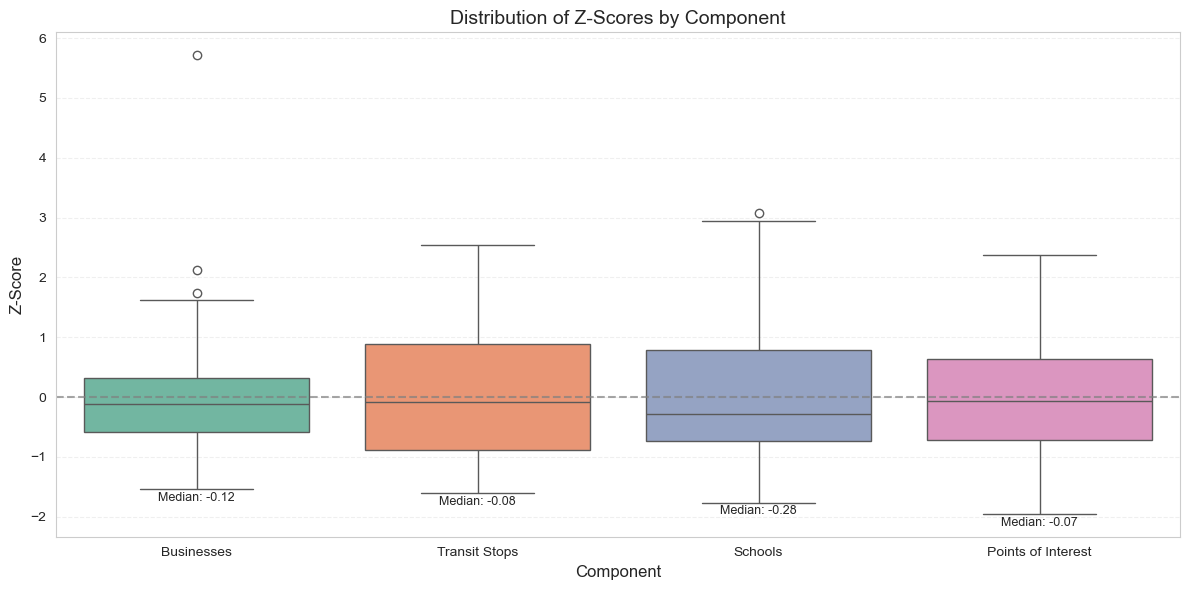

In [174]:
components_df = pd.read_sql(text("""
    SELECT
        sa2_name,
        z_business,
        z_stops,
        z_schools,
        z_poi,
        well_resourced_score
    FROM public.sa2_summary
    ORDER BY well_resourced_score DESC
"""), conn)

melted_df = pd.melt(components_df,
                    id_vars=['sa2_name', 'well_resourced_score'],
                    value_vars=['z_business', 'z_stops', 'z_schools', 'z_poi'],
                    var_name='Component',
                    value_name='Z-Score')

component_names = {
    'z_business': 'Businesses',
    'z_stops': 'Transit Stops',
    'z_schools': 'Schools',
    'z_poi': 'Points of Interest'
}
melted_df['Component'] = melted_df['Component'].map(component_names)

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='Component', y='Z-Score', palette='Set2', hue='Component')
plt.title('Distribution of Z-Scores by Component', fontsize=14)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', alpha=0.7, label='Zero Reference')

plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, comp in enumerate(component_names.values()):
    subset = melted_df[melted_df['Component'] == comp]['Z-Score']
    median = subset.median()
    plt.annotate(f'Median: {median:.2f}',
                 xy=(i, subset.min() - 0.2),
                 ha='center',
                 fontsize=9)

plt.tight_layout()
plt.show()

### 4.2 Distribution Summary

#### 4.2.1 Histogram of composite scores

Displays the overall distribution of the composite "well-resourced scores" across all analyzed SA2 regions. A histogram is generated to show the frequency of scores within different ranges, providing insight into whether scores are concentrated or spread out.

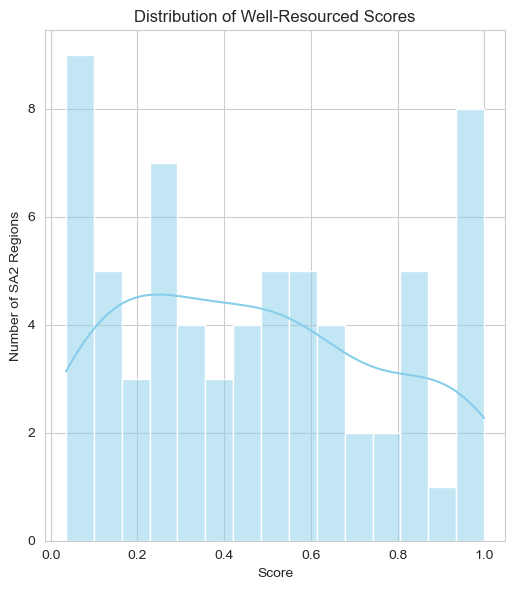

In [178]:
scores_df = pd.read_sql(text("""
    SELECT
        public.sa2_summary.sa2_name,
        well_resourced_score,
        sa4_name_2021
    FROM public.sa2_summary
    JOIN public.sa2_regions USING (sa2_code)
"""), conn)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(scores_df['well_resourced_score'], bins=15, kde=True, color='skyblue')
plt.title('Distribution of Well-Resourced Scores')
plt.xlabel('Score')
plt.ylabel('Number of SA2 Regions')

plt.tight_layout()
plt.show()

### 4.2.2 Overall stats (mean, median, std, IQR)
This code generates the overall statistics includes mean, median, spread which is standard deviation and interquartile range. It is done bymerging summary data with SA4 region names, compute the stats, then it groups the data by SA4 region and calculates the same metrics for each individual SA4. The results are merged into a single DataFrame and displayed as a table, allowing for a clear cross-region comparison.

### 4.3 Cross-Zone Comparison

In [180]:
summary_df = query(conn, "SELECT * FROM public.sa2_summary;")
sa2_regions_df = query(conn, "SELECT sa2_code, sa2_name, sa4_name_2021 FROM public.sa2_regions;")
summary_df = summary_df.merge(sa2_regions_df, on=["sa2_code", "sa2_name"], how="left")

q1 = summary_df["well_resourced_score"].quantile(0.25)
q3 = summary_df["well_resourced_score"].quantile(0.75)
iqr = q3 - q1

overall_stats = pd.DataFrame({
    "SA4 Region": ["Overall"],
    "Mean Score": [summary_df["well_resourced_score"].mean()],
    "Median Score": [summary_df["well_resourced_score"].median()],
    "Standard Deviation": [summary_df["well_resourced_score"].std()],
    "IQR": [iqr]
})

def calc_iqr(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    return q3 - q1

cross_zone_summary = summary_df.groupby("sa4_name_2021")["well_resourced_score"].agg(
    mean="mean",
    median="median",
    std="std",
    iqr=calc_iqr
).reset_index()

cross_zone_summary.columns = ["SA4 Region", "Mean Score", "Median Score", "Standard Deviation", "IQR"]

combined_summary = pd.concat([overall_stats, cross_zone_summary], ignore_index=True)

display(combined_summary)


,SA4 Region,Mean Score,Median Score,Standard Deviation,IQR
0,Overall,0.472897,0.456311,0.304489,0.472755
1,Sydney - Blacktown,0.332012,0.212802,0.317255,0.415446
2,Sydney - Parramatta,0.525907,0.574752,0.235973,0.316631
3,Sydney - Ryde,0.595746,0.553841,0.352898,0.651510


### 4.3 Cross-Zone Comparison

Compares the distribution of "well-resourced scores" across different SA4 zones. A boxplot visualization is used to illustrate differences or similarities in score distributions between these broader geographical areas, highlighting any systematic regional variations.

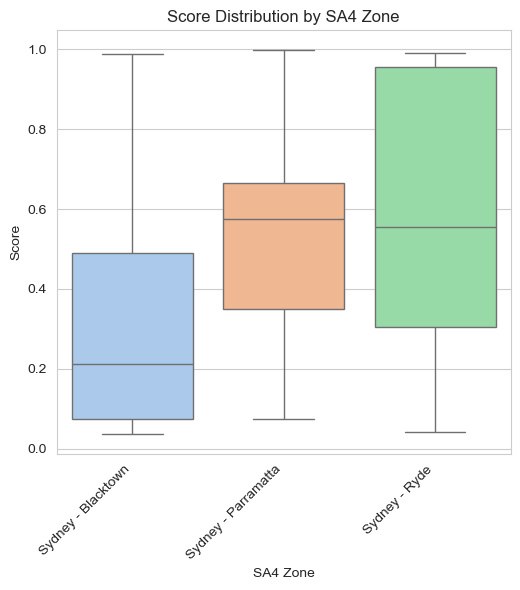

In [184]:
scores_df = pd.read_sql(text("""
    SELECT
        public.sa2_summary.sa2_name,
        well_resourced_score,
        sa4_name_2021
    FROM public.sa2_summary
    JOIN public.sa2_regions USING (sa2_code)
"""), conn)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 2)
sns.boxplot(data=scores_df, x='sa4_name_2021', y='well_resourced_score',
            hue='sa4_name_2021', palette='pastel')
plt.title('Score Distribution by SA4 Zone')
plt.xlabel('SA4 Zone')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 4.4 Noteworthy Patterns & Outliers

Identifies and visualizes the SA2 regions with the highest and lowest "well-resourced scores." A bar chart displays the top 5 and bottom 5 performing regions, allowing for a quick understanding of the extremes in resource distribution.

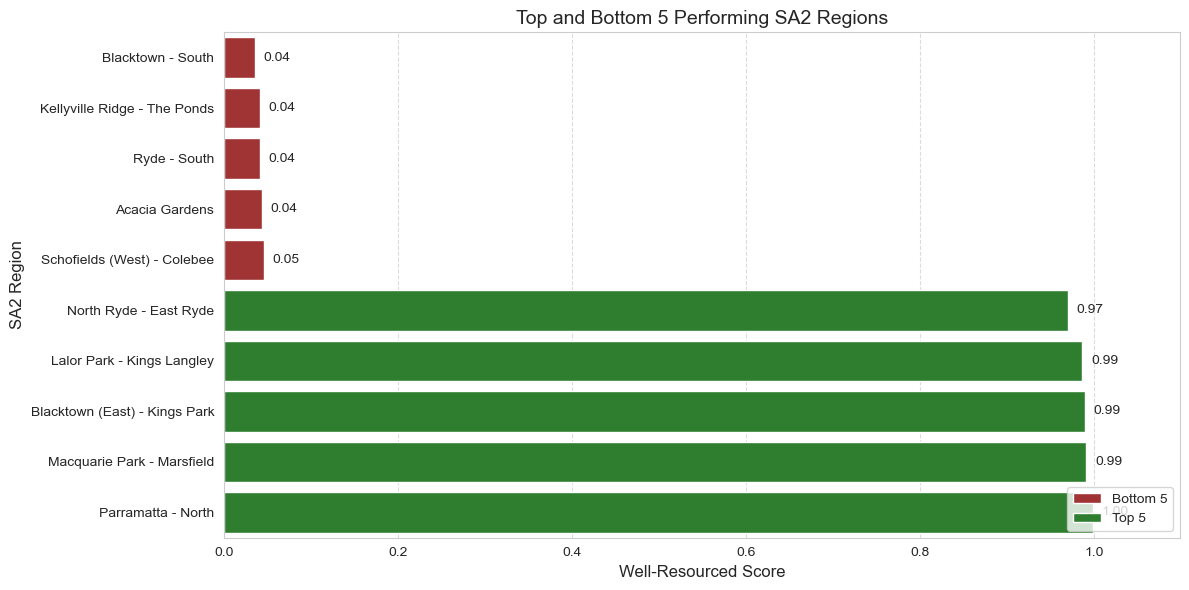

In [187]:
top_5 = components_df.nlargest(5, 'well_resourced_score')
bottom_5 = components_df.nsmallest(5, 'well_resourced_score')

top_5['category'] = 'Top 5'
bottom_5['category'] = 'Bottom 5'
top_bottom_df = pd.concat([top_5, bottom_5])

top_bottom_df = top_bottom_df.sort_values('well_resourced_score')

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_bottom_df,
                x='well_resourced_score',
                y='sa2_name',
                hue='category',
                palette={'Top 5': 'forestgreen', 'Bottom 5': 'firebrick'},
                dodge=False)

for i, v in enumerate(top_bottom_df['well_resourced_score']):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.title('Top and Bottom 5 Performing SA2 Regions', fontsize=14)
plt.xlabel('Well-Resourced Score', fontsize=12)
plt.ylabel('SA2 Region', fontsize=12)
plt.xlim(0, max(top_bottom_df['well_resourced_score']) * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.legend(title='', loc='lower right')

plt.tight_layout()
plt.show()

## 5. Correlation Analysis 

This section investigates the relationship between the "well-resourced scores" and socio-economic factors, specifically median income.

### 5.1 r & p-Value Calculation

Calculates the Pearson correlation coefficient (r) and p-value to assess the statistical relationship between "well-resourced scores" and median income. This is performed for all SA2 regions combined and then separately for SA2 regions within specific SA4 zones ("Sydney - Blacktown", "Sydney - Parramatta", "Sydney - Ryde") to identify if the correlation varies by larger geographical area.

In [192]:
summary_df_raw = query(
    conn,
    """
    SELECT
      s.sa2_name,
      r.sa4_name_2021,
      s.well_resourced_score,
      i.median_income
    FROM sa2_summary AS s
    JOIN income       AS i USING (sa2_name)
    JOIN sa2_regions  AS r USING (sa2_name)
    """
)
print(f"Rows fetched from SQL: {len(summary_df_raw)}")

# Handle potential non-string median_income before .str.replace
summary_df = summary_df_raw.copy() # Work on a copy
summary_df["median_income"] = summary_df["median_income"].astype(str).str.replace(",", "")
summary_df["median_income"] = pd.to_numeric(
    summary_df["median_income"],
    errors="coerce"
)
print(f"Rows after median_income numeric conversion: {len(summary_df)}")
print(f"NaNs in median_income after coercion: {summary_df['median_income'].isna().sum()}")
print(f"NaNs in well_resourced_score: {summary_df['well_resourced_score'].isna().sum()}")

summary_df = summary_df.dropna(subset=["well_resourced_score", "median_income"])
print(f"Rows after dropping NaNs for correlation: {len(summary_df)}")

r_overall, p_overall = pearsonr(
    summary_df["well_resourced_score"],
    summary_df["median_income"]
)
print(f"Overall (n={len(summary_df)}): Pearson r = {r_overall:.3f}, p = {p_overall:.3f}")

regions = ["Sydney - Blacktown", "Sydney - Parramatta", "Sydney - Ryde"]
for region in regions:
    sub = summary_df[summary_df["sa4_name_2021"] == region]
    r, p = pearsonr(sub["well_resourced_score"], sub["median_income"])
    print(f"{region} (n={len(sub)}): Pearson r = {r:.3f}, p = {p:.3f}")

Rows fetched from SQL: 67
Rows after median_income numeric conversion: 67
NaNs in median_income after coercion: 0
NaNs in well_resourced_score: 0
Rows after dropping NaNs for correlation: 67
Overall (n=67): Pearson r = -0.168, p = 0.174
Sydney - Blacktown (n=23): Pearson r = -0.550, p = 0.007
Sydney - Parramatta (n=31): Pearson r = 0.147, p = 0.430
Sydney - Ryde (n=13): Pearson r = 0.004, p = 0.989


### 5.2 Regression plot of score vs. median income

Visualizes the relationship between "well-resourced scores" and median income using a scatter plot with an overlaid regression line. This plot helps to illustrate the direction and strength of the correlation, and the calculated Pearson correlation coefficient is annotated on the plot.

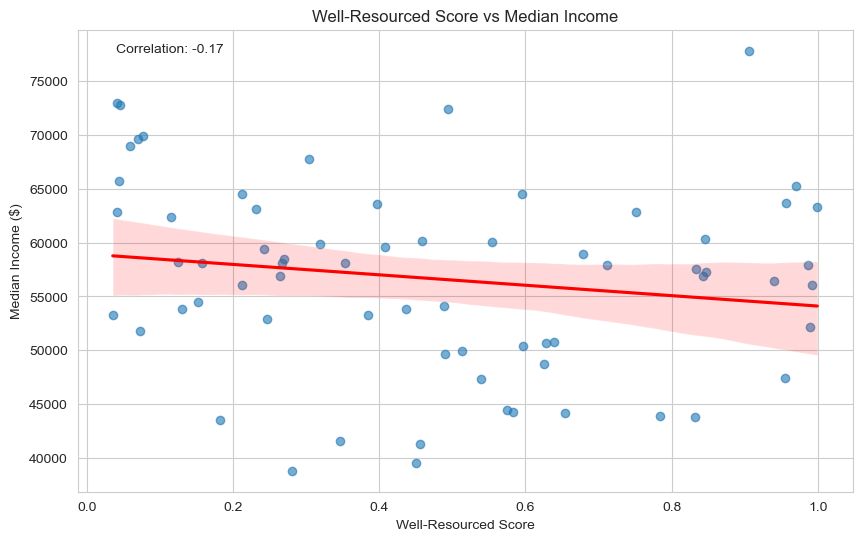

In [195]:
corr_df = pd.read_sql(text("""
    SELECT 
        ss.sa2_name,
        ss.well_resourced_score,
        i.median_income,
        sr.sa4_name_2021
    FROM public.sa2_summary ss
    JOIN public.income i ON ss.sa2_code::text = i.sa2_code21::text
    JOIN public.sa2_regions sr ON ss.sa2_code = sr.sa2_code
"""), conn)

corr_df['well_resourced_score'] = pd.to_numeric(corr_df['well_resourced_score'], errors='coerce')
corr_df['median_income'] = pd.to_numeric(corr_df['median_income'], errors='coerce')

corr_df = corr_df.dropna(subset=['well_resourced_score', 'median_income'])

plt.figure(figsize=(10, 6))
sns.regplot(data=corr_df, 
            x='well_resourced_score', 
            y='median_income',
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red'})

plt.title('Well-Resourced Score vs Median Income')
plt.xlabel('Well-Resourced Score')
plt.ylabel('Median Income ($)')
plt.grid(True)

# Calculate correlation coefficient
correlation = corr_df['well_resourced_score'].corr(corr_df['median_income'])
plt.annotate(f'Correlation: {correlation:.2f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

plt.show()

## 6. Geographic Visualization 

### 6.1 Static Choropleth Map

Creates a static choropleth map displaying the "well-resourced scores" for SA2 regions within selected SA4 zones ("Sydney - Blacktown", "Sydney - Parramatta", "Sydney - Ryde"). Scores are represented by a color gradient, SA4 boundaries are overlaid for context, and a basemap is included to provide geographic reference.


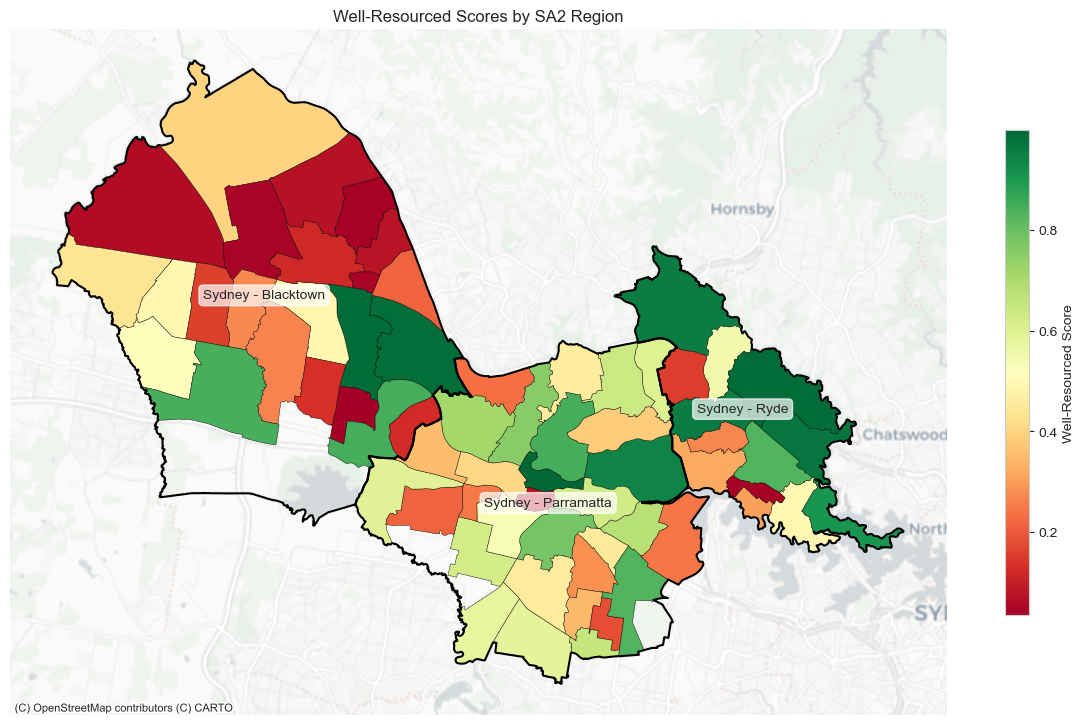

In [199]:
map_df = gpd.read_postgis(text("""
    SELECT
        sr.sa2_code,
        sr.sa2_name,
        sr.geometry,
        ss.well_resourced_score,
        sr.sa4_name_2021
    FROM public.sa2_regions sr
    JOIN public.sa2_summary ss ON sr.sa2_code = ss.sa2_code
    WHERE sr.sa4_name_2021 IN ('Sydney - Blacktown', 'Sydney - Parramatta', 'Sydney - Ryde')
"""), conn, geom_col='geometry')

fig, ax = plt.subplots(figsize=(12, 10))

map_df.plot(column='well_resourced_score',
            ax=ax,
            legend=True,
            legend_kwds={'label': "Well-Resourced Score", 'shrink': 0.5},
            cmap='RdYlGn',
            edgecolor='black',
            linewidth=0.3,
            missing_kwds={'color': 'lightgrey'})

sa4_boundaries = gpd.read_postgis(text("""
    SELECT
        sa4_name_2021,
        ST_Union(geometry) as geometry
    FROM public.sa2_regions
    WHERE sa4_name_2021 IN ('Sydney - Blacktown', 'Sydney - Parramatta', 'Sydney - Ryde')
    GROUP BY sa4_name_2021
"""), conn, geom_col='geometry')

sa4_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)

for idx, row in sa4_boundaries.iterrows():
    ax.annotate(text=row['sa4_name_2021'],
                xy=row['geometry'].centroid.coords[0],
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

ctx.add_basemap(ax, crs=map_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.title('Well-Resourced Scores by SA2 Region')
plt.axis('off')
plt.tight_layout()
plt.show()

### 6.2 Interactive Map

Generates an interactive choropleth map using Folium to visualize "well-resourced scores." The map includes features like hover tooltips displaying SA2 name, score, and SA4 region; multiple basemap options; a custom color legend; marker clusters for the top 5 regions; a title; layer control; fullscreen capability; and a measure tool for enhanced exploration.

In [202]:
m = folium.Map(location=[-33.8, 151.0], zoom_start=11, tiles='cartodbpositron')

folium.TileLayer('cartodbpositron', name='Light Map').add_to(m)
folium.TileLayer('cartodbdark_matter', name='Dark Map').add_to(m)
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain', name='Terrain').add_to(m)

def get_color(score):
    if score is None:
        return '#CCCCCC'
    elif score >= 0.8:
        return '#1a9850'
    elif score >= 0.6:
        return '#91cf60'
    elif score >= 0.4:
        return '#ffffbf'
    elif score >= 0.2:
        return '#fc8d59'
    else:
        return '#d73027'

def style_function(feature):
    score = feature['properties']['well_resourced_score']
    return {
        'fillColor': get_color(score),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

def highlight_function(feature):
    return {
        'weight': 3,
        'color': '#666',
        'dashArray': '',
        'fillOpacity': 0.9
    }

choropleth = folium.GeoJson(
    map_df,
    name='Well-Resourced Scores',
    style_function=style_function,
    highlight_function=highlight_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['sa2_name', 'well_resourced_score', 'sa4_name_2021'],
        aliases=['Area:', 'Score:', 'Region:'],
        localize=True,
        sticky=True,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px 3px 3px rgba(0,0,0,0.4);
            font-size: 14px;
            padding: 10px;
        """
    )
).add_to(m)

legend_html = '''
    <div style="position: fixed;
        bottom: 50px; right: 50px; width: 180px; height: 170px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color: white; padding: 10px; border-radius: 5px">
    <p style="margin-top: 0; margin-bottom: 5px;"><b>Well-Resourced Score</b></p>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="background-color:#1a9850; width:20px; height:20px; display:inline-block; margin-right:5px;"></span>
        <span>0.8 - 1.0</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="background-color:#91cf60; width:20px; height:20px; display:inline-block; margin-right:5px;"></span>
        <span>0.6 - 0.8</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="background-color:#ffffbf; width:20px; height:20px; display:inline-block; margin-right:5px;"></span>
        <span>0.4 - 0.6</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="background-color:#fc8d59; width:20px; height:20px; display:inline-block; margin-right:5px;"></span>
        <span>0.2 - 0.4</span>
    </div>
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <span style="background-color:#d73027; width:20px; height:20px; display:inline-block; margin-right:5px;"></span>
        <span>0.0 - 0.2</span>
    </div>
    </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

marker_cluster = MarkerCluster(name="Top Regions").add_to(m)

top_regions = map_df.nlargest(5, 'well_resourced_score')
for idx, row in top_regions.iterrows():
    centroid = row['geometry'].centroid
    popup_text = f"""
    <b>{row['sa2_name']}</b><br>
    Score: {row['well_resourced_score']:.2f}<br>
    Region: {row['sa4_name_2021']}
    """

    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='green', icon='star', prefix='fa'),
        tooltip=f"Top Region: {row['sa2_name']}"
    ).add_to(marker_cluster)

title_html = '''
    <div style="position: fixed;
        top: 10px; left: 50%; transform: translateX(-50%);
        z-index:9999; font-size:18px; font-weight: bold;
        background-color: white; padding: 10px; border-radius: 5px;
        border:2px solid grey; text-align: center;">
        Well-Resourced Scores by SA2 Region - Sydney
    </div>
'''
m.get_root().html.add_child(folium.Element(title_html))

folium.LayerControl(collapsed=False).add_to(m)

from folium.plugins import Fullscreen
Fullscreen().add_to(m)

from folium.plugins import MeasureControl
m.add_child(MeasureControl(position='topleft', primary_length_unit='kilometers'))

m

## 7. Scrutiny of Results

### 7.1 Sensitivity testing 
Assesses the impact of individual components (z_business, z_stops, z_schools, z_poi) on the final "well-resourced score" and its ranking. This involves:
1. Calculating the direct Pearson correlation of each component's z-score with the composite score.
2. Performing a leave-one-out analysis: each component is temporarily removed, the composite score is recalculated, and the Spearman rank correlation between the original ranking and the new ranking is computed.
3. Comparing distributional statistics (mean, median, standard deviation) of the original composite score with those of scores recalculated after dropping each component.


In [206]:
sql = """
SELECT
  s.sa2_name,
  r.sa4_name_2021,
  s.well_resourced_score,
  s.z_business,
  s.z_stops,
  s.z_schools,
  s.z_poi,
  i.median_income
FROM sa2_summary AS s
JOIN income     AS i USING (sa2_name)
JOIN sa2_regions AS r USING (sa2_name)
"""
df = query(conn, sql).dropna()

if df["median_income"].dtype == "object":
    df["median_income"] = df["median_income"].str.replace(",", "")
    df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")
df = df.dropna(subset=["well_resourced_score", "median_income"])

components    = ["z_business", "z_stops", "z_schools", "z_poi"]
composite_col = "well_resourced_score"

print("1) Direct Pearson correlations with final score:")
for comp in components:
    r, p = pearsonr(df[comp], df[composite_col])
    print(f"   {comp:>12s} → r = {r:.3f}, p = {p:.3f}")

orig_rank = df[composite_col].rank(method="average")
print("\n2) Leave-one-out Spearman rank correlations:")
for comp in components:
    others   = [c for c in components if c != comp]
    raw_sum  = df[others].sum(axis=1)
    mod_score = 1 / (1 + np.exp(-raw_sum))
    mod_rank  = mod_score.rank(method="average")
    rho, p    = spearmanr(orig_rank, mod_rank)
    print(f"   without {comp:>8s} → ρ = {rho:.3f}, p = {p:.3f}")

orig_stats = (
    df[composite_col].mean(),
    df[composite_col].median(),
    df[composite_col].std()
)
print("\n3) Distribution statistics comparison (mean, median, std):")
print(f"   original       : mean = {orig_stats[0]:.3f}, median = {orig_stats[1]:.3f}, std = {orig_stats[2]:.3f}")
for comp in components:
    others    = [c for c in components if c != comp]
    raw_sum   = df[others].sum(axis=1)
    mod_score = 1 / (1 + np.exp(-raw_sum))
    stats     = (mod_score.mean(), np.median(mod_score), mod_score.std())
    print(f"   without {comp:>8s} : mean = {stats[0]:.3f}, median = {stats[1]:.3f}, std = {stats[2]:.3f}")

1) Direct Pearson correlations with final score:
     z_business → r = 0.424, p = 0.000
        z_stops → r = 0.497, p = 0.000
      z_schools → r = 0.303, p = 0.013
          z_poi → r = 0.745, p = 0.000

2) Leave-one-out Spearman rank correlations:
   without z_business → ρ = 0.888, p = 0.000
   without  z_stops → ρ = 0.849, p = 0.000
   without z_schools → ρ = 0.844, p = 0.000
   without    z_poi → ρ = 0.844, p = 0.000

3) Distribution statistics comparison (mean, median, std):
   original       : mean = 0.473, median = 0.456, std = 0.304
   without z_business : mean = 0.488, median = 0.430, std = 0.296
   without  z_stops : mean = 0.472, median = 0.403, std = 0.291
   without z_schools : mean = 0.493, median = 0.513, std = 0.315
   without    z_poi : mean = 0.477, median = 0.416, std = 0.254
